In [1]:
# Imports

import sklearn
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np
import cv2
from os import listdir
from os.path import isfile, join
import pandas as pd
import re
from glob import glob
from matplotlib import pyplot as plt
from datetime import datetime

In [2]:
# Directory Path:
IMG_PATH = "../data/pets/train/"
LABEL_PATH = "../data/pets/train_label.txt"

# Constants
NUM_IMG = 2000
N_CLUSTER = 200 # K-means 

In [3]:
# Image Processing & General Feature Extraction

# Gray scale image
def gray(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# SIFT feature
def get_features(image, SIFT_obj):
    keypoints, features = SIFT_obj.detectAndCompute(image, None) # Don't need grayscale image here
    return keypoints, features


In [4]:
# Deeper Feature Extraction

# Bag of word
# clustering
def bow_cluster(kmeans_obj, descriptor_stack):
    kmeans_ret = kmeans_obj.fit_predict(descriptor_stack)
    return kmeans_ret

# generate vertical stack of descriptors
def bow_vstack(desc_list):
    stack = np.array(desc_list[0])
    for rest in desc_list[1:]:
        stack = np.vstack((stack, rest))
    desc_stack = stack.copy()
    return desc_stack

# generate bag of words frequency matrix (shape: NUM_TRAIN_IMG * N_CLUSTER)
def bow_get_freq_matrix(num_imgs, num_clusters, SIFT_list, kmeans_ret):
    # initialization
    matrix = np.array([np.zeros(num_clusters) for i in range(num_imgs)])
    
    # keep track of index of kmeans_ret
    kmeans_id = 0
    for i in range(num_imgs):
        l = len(SIFT_list[i])
        for j in range(l):
            cluster_id = kmeans_ret[kmeans_id + j]
            matrix[i][cluster_id] += 1
        kmeans_id += l
    
    return matrix
            

In [5]:
# Read In Image Files
def get_images(path):
    imlist = []
    for i in range(NUM_IMG):
        path_str = path + "pet" + str(i+1) + ".jpg"
        im = cv2.imread(path_str)
        imlist.append(im)
        
    return imlist

In [6]:
start_time = datetime.now()
print("Reading Images @ " + str(start_time))
imlist = get_images(IMG_PATH) # imlist contains a list of image numpy arrays
end_time = datetime.now()
print("Complete @ " + str(end_time) + " Time Cost: " + str(end_time - start_time))

Reading Images @ 2018-03-01 00:24:42.330761
Complete @ 2018-03-01 00:24:52.314638 Time Cost: 0:00:09.983877


In [7]:
print(len(imlist))

2000


In [8]:
# Read In Labels
def get_labels(path):
    labels = np.loadtxt(path, dtype = 'str')
    np.reshape(labels, (-1, 1))
    return labels

In [9]:
labellist = get_labels(LABEL_PATH)

In [10]:
print(labellist.shape)

(2000,)


In [11]:
## Compute SIFT features
start_time = datetime.now()
print("Generating SIFT features @ " + str(start_time))
SIFT_obj = cv2.xfeatures2d.SIFT_create()
SIFT_list = []
for im in imlist:
    keypoint, descriptor = get_features(im, SIFT_obj)
    SIFT_list.append(descriptor)
end_time = datetime.now()
print("SIFT features complete @ " + str(end_time) + " Time Cost: " + str(end_time - start_time))

Generating SIFT features @ 2018-03-01 00:24:52.355506
SIFT features complete @ 2018-03-01 00:25:42.380249 Time Cost: 0:00:50.024743


In [12]:
# Generate a vertical stack of descriptors to perform clustering
start_time = datetime.now()
print("Generating SIFT stacked matrix @ " + str(start_time))
descriptor_stack = bow_vstack(SIFT_list)

end_time = datetime.now()
print("Matrix complete @ " + str(end_time) + " Time Cost: " + str(end_time - start_time))
print("Shape of vstack matrix: " + str(descriptor_stack.shape))

Generating SIFT stacked matrix @ 2018-03-01 00:25:42.387726
Matrix complete @ 2018-03-01 00:34:06.609805 Time Cost: 0:08:24.222079
Shape of vstack matrix: (1592982, 128)


In [13]:
# BOW clustering
start_time = datetime.now()
print("Start Clustering @ " + str(start_time))

kmeans_obj = KMeans(n_clusters = N_CLUSTER)
kmeans_ret = bow_cluster(kmeans_obj, descriptor_stack)

end_time = datetime.now()
print("Matrix complete @ " + str(end_time) + " Time Cost: " + str(end_time - start_time))
print("Shape of kmeans ret: " + str(kmeans_ret.shape))

Start Clustering @ 2018-03-01 00:34:06.632200
Matrix complete @ 2018-03-01 10:47:12.328965 Time Cost: 10:13:05.696765
Shape of kmeans ret: (1592982,)


Generating BOW Vocabulary @ 2018-03-01 10:47:12.363557
BOW Vocabulary complete @ 2018-03-01 10:47:13.533568 Time Cost: 0:00:01.170011
Plot Histogram of entire dataset (x = vocabulary, y = count)


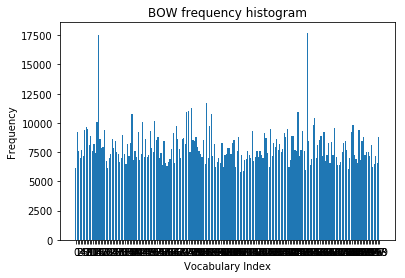

In [14]:
start_time = datetime.now()
print("Generating BOW Vocabulary @ " + str(start_time))

vocab_matrix = bow_get_freq_matrix(NUM_IMG, N_CLUSTER, SIFT_list, kmeans_ret)

#### IMPORTANT: FOR SVM, STANDARDIZE DATA BEFORE FEEDING INTO SVC()
scale = StandardScaler().fit(vocab_matrix)
vocab_matrix_std = scale.transform(vocab_matrix)

end_time = datetime.now()
print("BOW Vocabulary complete @ " + str(end_time) + " Time Cost: " + str(end_time - start_time))
print("Plot Histogram of entire dataset (x = vocabulary, y = count)")
x_scalar = np.arange(N_CLUSTER)
y_scalar = np.array([abs(np.sum(vocab_matrix[:, h], dtype = np.int32)) for h in range(N_CLUSTER)])
plt.bar(x_scalar, y_scalar)
plt.xlabel("Vocabulary Index")
plt.ylabel("Frequency")
plt.title("BOW frequency histogram")
plt.xticks(x_scalar + 0.4, x_scalar)
plt.show()

In [15]:
print(vocab_matrix.shape)

(2000, 200)


In [16]:
train_labels = np.asarray(labellist)
print(train_labels.shape)
print(vocab_matrix_std.shape)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(vocab_matrix_std, train_labels, test_size = 0.2, random_state =42)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(2000,)
(2000, 200)
(1600, 200)
(400, 200)
(1600,)
(400,)


In [17]:
start_time = datetime.now()
print("Start training using SVM @ " + str(start_time))

clf = SVC()
clf.fit(X_train, y_train)
pred = np.asarray(clf.predict(X_test))
accuracy = (pred == y_test).mean()
print("Accuracy: %.2f%%" % (accuracy * 100))
end_time = datetime.now()
print("End training @ " + str(end_time) + " Time Cost: " + str(end_time - start_time))

Start training using SVM @ 2018-03-01 10:47:14.630241
Accuracy: 76.50%
End training @ 2018-03-01 10:47:15.249083 Time Cost: 0:00:00.618842


In [18]:
# Save vocabulary feature matrix to output folder in csv format and npy format
from pandas import DataFrame
df = DataFrame(data = vocab_matrix)
df.index.name = 'IMG_ID'
column_name_list = []
for i in range(N_CLUSTER):
    column_name_list.append('CLUSTER_ID_' + str(i))
df.columns = column_name_list
df.to_csv('../output/BOWmatrix-' + str(N_CLUSTER) + '.csv', mode = 'a', index = True, sep = ',')
np.save('../output/BOWmatrix-' + str(N_CLUSTER) + '.npy', df)



In [19]:
df2 = DataFrame(data = vocab_matrix_std)
df2.index.name = 'IMG_ID'
df2.columns = column_name_list
df2.to_csv('../output/BOWmatrix_std-' + str(N_CLUSTER) + '.csv', mode = 'a', index = True, sep = ',')
np.save('../output/BOWmatrix_std' + str(N_CLUSTER) + '.npy', df2)

In [20]:
from sklearn.externals import joblib
kmeans_filename = '../output/kmeans' + str(N_CLUSTER) + '.sav'
print("Saving kmeans model")
joblib.dump(kmeans_obj, kmeans_filename)
print("Saving complete")

Saving kmeans model
Saving complete


In [21]:
# Test saving
model = joblib.load(kmeans_filename)
SIFT_obj_tmp = cv2.xfeatures2d.SIFT_create()
kp, des = get_features(imlist[0], SIFT_obj_tmp)
print("Shape of descriptor: " + str(des.shape))
vocab = np.array( [[ 0 for i in range(N_CLUSTER)]])
test_ret = model.predict(des)
print("Shape of ret: " + str(test_ret.shape))
for i in test_ret:
    vocab[0][i] += 1
vocab = scale.transform(vocab)
pred_test = clf.predict(vocab)
print(pred_test)

Shape of descriptor: (568, 128)
Shape of ret: (568,)
['"dog"']


/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
